In [1]:
import wandb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [2]:
loss_key = "train/elbo"

In [3]:
# fit to
# L = C + B / (t**b)

def loss_curve(steps, C, B, b):
    return C + B * steps**(-b)

def fit_loss_curve(history, x_key="_step", y_key="train/elbo", min_x=2000, max_x=None):

    h = history.copy()
    if min_x is not None:
        h = h.loc[h[x_key] >= min_x]
    if max_x is not None:
        h = h.loc[h[x_key] <= max_x]
    popt, pcov = curve_fit(loss_curve, h[x_key], h[y_key], p0=(0.0, 1.0, 1.0), maxfev=10000)

    r2 = 1 - (np.sum((h[y_key] - loss_curve(h[x_key], *popt)) ** 2) / np.sum((h[y_key] - np.mean(h[y_key])) ** 2))

    y_hat = loss_curve(history[x_key], *popt)

    return y_hat, popt, r2


In [4]:
runs = wandb.Api().runs(
    path="dvruette/EasyDeL-diffusiontrainer-Gidd",
    order="config.lr",
    filters={
        "tags": "verify_mup",
    }
)

histories = [
    run.history(keys=["train/loss", "train/elbo", "train/visited_tokens"])
    for run in runs
]

len(runs)

12

In [5]:
all_popts = []
lrs = [run.config.get("aux_lr") for run in runs]
for i, history in enumerate(histories):
    y_hat, popt, r2 = fit_loss_curve(history, y_key=loss_key, min_x=2000, max_x=None)
    all_popts.append(popt)

tiny [4.796398448944092, 4.710751056671143, 4.671074771881104, 4.757005214691162]
tiny [4.597018003463745, 4.48127703666687, 4.46801266670227, 4.509587907791138]
tiny [4.335520648956299, 4.262126064300537, 4.263463354110717, 4.325797414779663]
tiny [4.224379348754883, 4.109877347946167, 4.141728782653809, 4.2144670486450195]
tiny [4.10407555103302, 4.025212264060974, 4.031265091896057, 4.074319577217102]
small [4.789996337890625, 4.687598848342896, 4.674379444122314, 4.704454708099365]
small [4.557827615737915, 4.371093320846557, 4.360052919387817, 4.48331880569458]
small [4.313443660736084, 4.199286699295044, 4.218597793579102, 4.2730859279632565]
small [4.149287557601928, 4.0634479999542235, 4.071760368347168, 4.108400774002075]
small [3.9923346757888796, 3.8815667390823365, 3.9120916366577148, 3.9598486185073853]
base [4.773856449127197, 4.678266286849976, 4.6121087074279785, 4.690178966522216]
base [4.516291904449463, 4.386954927444458, 4.3276149272918705, 4.414085865020752]
base [

/tmp/ipykernel_675329/18229008.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closest_ys.append(float(closest_y))


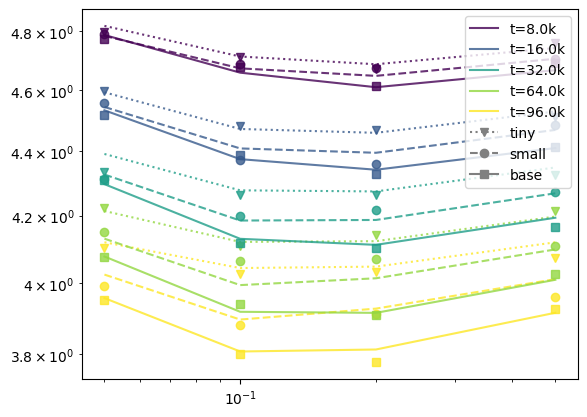

In [11]:
cmap = plt.get_cmap("viridis")

ts = [8e3, 16e3, 32e3, 64e3, 96e3]

# lrs = [run.config.get("lr") for run in runs]
for size, marker, linestyle in zip(["tiny", "small", "base"], ["v", "o", "s"], [":", "--", "-"]):
    ids = [i for i, run in enumerate(runs) if size in run.tags]
    lrs = [runs[i].config.get("lr") for i in ids]
    for t in ts:
        color = cmap((np.log10(t) - np.log10(min(ts))) / (np.log10(max(ts)) - np.log10(min(ts))))

        ys = []
        closest_ys = []
        for i in ids:
            run = runs[i]
            history = histories[i]
            popt = all_popts[i]

            ys.append(loss_curve(t, *popt))

            closest_t = history.loc[(history["_step"] - t).abs().sort_values().index[0], "_step"]
            if abs(closest_t - t) < 1000:
                closest_y = history[loss_key].rolling(10, center=True).mean().loc[history["_step"] == closest_t]
                closest_ys.append(float(closest_y))
            else:
                closest_ys.append(np.nan)

        print(size, closest_ys)

        label = f"t={t/1000:.1f}k" if linestyle == "-" else None
        plt.plot(lrs, ys, label=label, marker="none", linestyle=linestyle, color=color, alpha=0.8)
        plt.plot(lrs, closest_ys, marker=marker, linestyle="none", color=color, alpha=0.8)

plt.plot([], [], label="tiny", marker="v", linestyle=":", color="grey")
plt.plot([], [], label="small", marker="o", linestyle="--", color="grey")
plt.plot([], [], label="base", marker="s", linestyle="-", color="grey")

# lrs = [run.config.get("aux_lr") for run in runs]
# for t in ts:
#     ys = [loss_curve(t, *popt) for popt in all_popts]
#     xs, ys = zip(*sorted(zip(lrs, ys)))
#     color = cmap((np.log10(t) - np.log10(min(ts))) / (np.log10(max(ts)) - np.log10(min(ts))))

#     plt.plot(xs, ys, label=f"t={t/1000:.1f}k", marker="none", color=color)

#     y_true_ids = [history.loc[(history["_step"] - t).abs().sort_values().index[0], "_step"] for history in histories]
#     y_true_smoothed = [history[loss_key].rolling(10, center=True).mean().loc[history["_step"] == idx] for idx, history in zip(y_true_ids, histories)]
#     xs, y_true_smoothed = zip(*sorted(zip(lrs, y_true_smoothed)))
#     plt.plot(xs, y_true_smoothed, marker="o", linestyle=":", color=color)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right");
